<a href="https://colab.research.google.com/github/DanieloSendi/Deep-Learning-Lab/blob/main/08_U_Net_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **U-Net Segmentation**

## 1. Download data

The first step is to download the data by executing the commands below in the terminal or extract it in another way.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

# !tar -xf /content/drive/MyDrive/Machine\ Learning/images.tar.gz
# !tar -xf /content/drive/MyDrive/Machine\ Learning/annotations.tar.gz

--2024-12-21 22:17:36--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-12-21 22:17:37--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  26.0MB/s    in 29s     

2024-12-21 22:18:07 (25.9 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2024-12-21 22:18:07--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.r

The data represents images of animals, along with segmentation masks indicating the object's location in the image with pixel-level accuracy. The images should be loaded as two separate sorted lists: one containing images and the other containing masks.

It is important to ensure that the i-th image in the first list corresponds to the i-th mask in the second list. Additionally, due to the quantity and size of the images, they may not fit into memory. Therefore, a good idea would be to store their paths and load them during training.

## Dataset configuration

In [ ]:
# Set the necessary paths
# Choose parameters depending on hardware capabilities
# Check if the data has been downloaded correctly.

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)

# Object, background, uncertain area between
num_classes = 3
batch_size = 16

# Sort images and masks
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [ ]:
print("Number of samples:", len(input_img_paths))

Number of samples: 7390


You can plot a sample image and mask using the imshow function from the pyplot module of the matplotlib library:

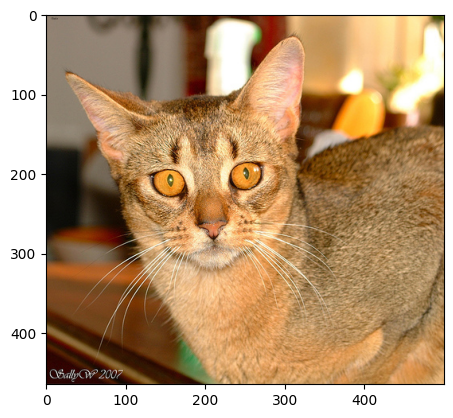

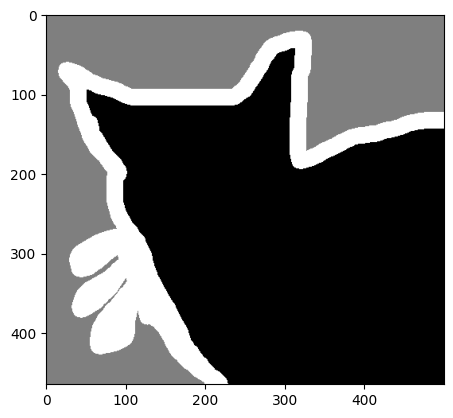

In [ ]:
img = load_img(input_img_paths[4])
plt.imshow(img)
plt.show()

mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[4]))
plt.imshow(mask)
plt.show()

## 3. Implement genrator

To be able to load images during training, it is necessary to implement an appropriate generator. None of the available generators loads images and their masks. Therefore, it is necessary to write your own generator. Such a class must inherit from the keras.utils.Sequence class and implement the methods: `len(self)` and `getitem(self, idx)`.

Alternatively, you can use existing tools and use two separate generators - one that loads images and another that loads masks, and then combine them into one.

In [ ]:
# For our custom function to function as a generator and be usable, for example, by fit,
# it must have three definitions: __init__, __len__, and __getitem__.
class DataGen(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            # x[j] = img
            x[j] = np.array(img) / 255.0
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1

        return x, y

The `getitem` method is called for each batch once during one epoch by passing an index. The method should return a tuple with two elements, where the first element is a set of images with the size (batch size, height, width, number of channels), and the second element represents the set of masks for the loaded images. This prepared object of the class is passed to the fit method, which implements the training process.

However, it is necessary to implement the architecture of the network beforehand. It has a U-shaped structure, and the operations within it include convolutions, max pooling operations, and transposed convolutions. The input to the network is an image, while the output is a mask. It is good to start with the definition of helper functions.

## 4. Define U-net model

A convolutional block:

In [ ]:
#remember to add padding
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

DownSampling block:

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

Upsampling block:

In [ ]:
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

Given all these operations, we can implement the network:

In [ ]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = double_conv_block(p4, 1024)

    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

keras.backend.clear_session()

model = get_model(img_size, num_classes)

In [ ]:
keras.backend.clear_session()

model = get_model(img_size, num_classes)

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 160, 160, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 160, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 80, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 80, 80, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 80, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 80, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 40, 40, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 40, 40, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 40, 40, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 20, 20, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 20, 20, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 20, 20, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 20, 20, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 10, 10, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 10, 10, 512)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

To verify the network architecture, you can print it to the screen using model.summary().

A good practice is to split the dataset into training, validation, and test subsets. It is necessary to divide the dataset into appropriate subsets. For simplicity, two sets are sufficient – training and validation.

## 5. Split dataset for train and validation sets

In [ ]:
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# data_pairs = list(zip(input_img_paths, target_img_paths))
# random.Random(1337).shuffle(data_pairs)
# input_img_paths, target_img_paths = zip(*data_pairs)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

Next step, create generator objects:

In [ ]:
train_gen = DataGen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 6. Metrics for segmentation (e.g., Dice, Jaccard).

Before starting the training itself, it is necessary to define the loss function and compile the model. Additionally, it is advisable to set up a callback to save the best model. Finally, the fit function is called with the appropriate arguments.

During training, the Keras library logs real-time progress. The training time may vary depending on the available hardware. If the waiting time is too long, consider reducing the dataset or the number of epochs. However, note that excessively short training time may result in poor model performance.

The effectiveness of the model can be assessed using a metric (e.g., accuracy), although it is generally not applied to segmentation problems.

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

In [ ]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred):
    """
    Calculate the Dice Coefficient (F1-score) for multi-class segmentation tasks.

    The Dice Coefficient measures the overlap between the predicted segmentation
    and the ground truth. It ranges from 0 to 1, where 1 indicates perfect overlap.

    Parameters:
    ----------
    y_true : Tensor
        Ground truth tensor. It can be sparse (integer labels) or one-hot encoded.
        Shape: (batch_size, height, width, 1) for sparse labels or
               (batch_size, height, width, num_classes) for one-hot encoded labels.
    y_pred : Tensor
        Predicted tensor with class probabilities (output of softmax).
        Shape: (batch_size, height, width, num_classes).

    Returns:
    -------
    Tensor
        Dice coefficient averaged over all classes.
        Shape: Scalar (single value).

    Notes:
    -----
    - Sparse ground truth labels are automatically converted to one-hot encoding.
    - A small epsilon value (1e-7) is added for numerical stability.
    """
    # One-hot encode `y_true` if it's sparse
    if K.int_shape(y_true)[-1] != K.int_shape(y_pred)[-1]:
        y_true = K.squeeze(K.one_hot(K.cast(y_true, 'int32'), num_classes=K.int_shape(y_pred)[-1]), axis=-2)

    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    denominator = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])

    dice = (2.0 * intersection + 1e-7) / (denominator + 1e-7)
    return K.mean(dice)

def jaccard_index(y_true, y_pred):
    """
    Calculate the Jaccard Index (Intersection over Union, IoU) for multi-class segmentation.

    The Jaccard Index measures the similarity between the predicted segmentation
    and the ground truth by dividing the intersection by the union of the two sets.

    Parameters:
    ----------
    y_true : Tensor
        Ground truth tensor. It can be sparse (integer labels) or one-hot encoded.
        Shape: (batch_size, height, width, 1) for sparse labels or
               (batch_size, height, width, num_classes) for one-hot encoded labels.
    y_pred : Tensor
        Predicted tensor with class probabilities (output of softmax).
        Shape: (batch_size, height, width, num_classes).

    Returns:
    -------
    Tensor
        Jaccard index averaged over all classes.
        Shape: Scalar (single value).

    Notes:
    -----
    - Sparse ground truth labels are automatically converted to one-hot encoding.
    - A small epsilon value (1e-7) is added for numerical stability.
    - The IoU is commonly used as an evaluation metric in segmentation tasks.
    """
    # One-hot encode `y_true` if it's sparse
    if K.int_shape(y_true)[-1] != K.int_shape(y_pred)[-1]:
        y_true = K.squeeze(K.one_hot(K.cast(y_true, 'int32'), num_classes=K.int_shape(y_pred)[-1]), axis=-2)

    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection

    jaccard = (intersection + 1e-7) / (union + 1e-7)
    return K.mean(jaccard)


## 7. Train model

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=[dice_coefficient, jaccard_index])

callbacks = [keras.callbacks.ModelCheckpoint("unet.keras", save_best_only=True)]

In [ ]:
epochs = 15
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=val_gen,
                    callbacks=callbacks)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


399/399 ━━━━━━━━━━━━━━━━━━━━ 213s 414ms/step - dice_coefficient: 0.3535 - jaccard_index: 0.2362 - loss: 0.8941 - val_dice_coefficient: 0.4452 - val_jaccard_index: 0.3121 - val_loss: 0.7137
Epoch 2/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 205s 378ms/step - dice_coefficient: 0.4600 - jaccard_index: 0.3263 - loss: 0.7171 - val_dice_coefficient: 0.4165 - val_jaccard_index: 0.2824 - val_loss: 0.9241
Epoch 3/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 155s 388ms/step - dice_coefficient: 0.5405 - jaccard_index: 0.4031 - loss: 0.5985 - val_dice_coefficient: 0.5798 - val_jaccard_index: 0.4406 - val_loss: 0.5161
Epoch 4/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 197s 375ms/step - dice_coefficient: 0.5951 - jaccard_index: 0.4582 - loss: 0.5167 - val_dice_coefficient: 0.6190 - val_jaccard_index: 0.4844 - val_loss: 0.5309
Epoch 5/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 206s 385ms/step - dice_coefficient: 0.6352 - jaccard_index: 0.5011 - loss: 0.4555 - val_dice_coefficient: 0.6962 - val_jaccard_index: 0.5703 - val_loss: 0.4017
Epoch 6/15


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['dice_coefficient', 'jaccard_index', 'loss', 'val_dice_coefficient', 'val_jaccard_index', 'val_loss'])

## 8. Outcome analysis

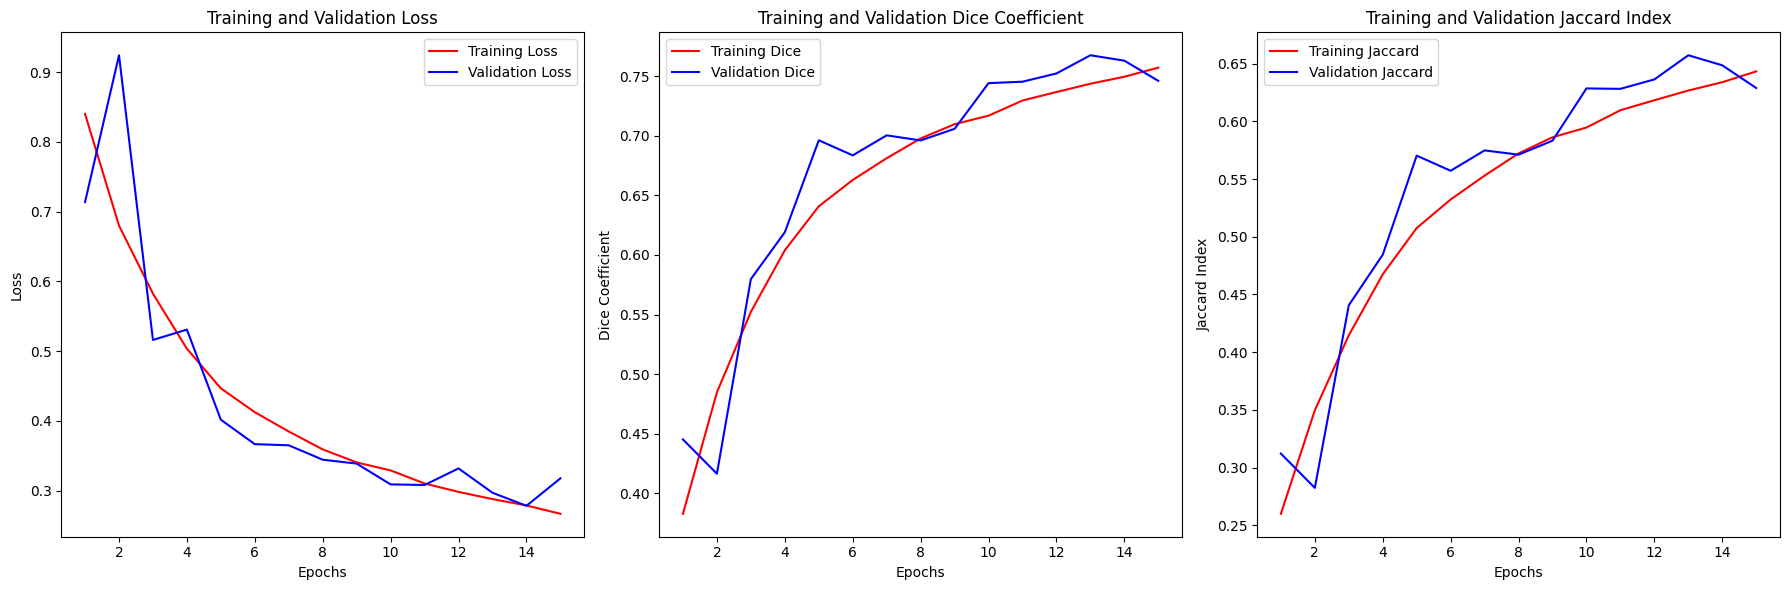

In [ ]:
# Extract values from the training history
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']
training_dice = history_dict['dice_coefficient']
validation_dice = history_dict['val_dice_coefficient']
training_jaccard = history_dict['jaccard_index']
validation_jaccard = history_dict['val_jaccard_index']

# Setup the subplots for metrics
plt.figure(figsize=(18, 6))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, 'r-', label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation Dice Coefficient
plt.subplot(1, 3, 2)
plt.plot(range(1, len(training_dice) + 1), training_dice, 'r-', label='Training Dice')
plt.plot(range(1, len(validation_dice) + 1), validation_dice, 'b-', label='Validation Dice')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot training and validation Jaccard Index
plt.subplot(1, 3, 3)
plt.plot(range(1, len(training_jaccard) + 1), training_jaccard, 'r-', label='Training Jaccard')
plt.plot(range(1, len(validation_jaccard) + 1), validation_jaccard, 'b-', label='Validation Jaccard')
plt.title('Training and Validation Jaccard Index')
plt.xlabel('Epochs')
plt.ylabel('Jaccard Index')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
